# MDI+: Example Usages

In [22]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import shap
import lime
import time
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error
import copy

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [23]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [24]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n) > np.mean(np.matmul(X, beta) + np.random.normal(size=n))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

In [15]:
rf_plus_model = RandomForestPlusClassifier(rf_model=rf_classifier, calc_loo_coef=False)
rf_plus_model.fit(X_train, y_train)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [25]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor,
                                          include_raw=False, cv_ridge=0,
                                          calc_loo_coef=False,
                                          sample_split="oob", fit_on="test")
rf_plus_model.fit(X_train, y_train)

In [28]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True,
                                                    lfi_abs = "none",
                                                    train_or_test = "test",
                                                    sample_split=None)


In [30]:
mdi_plus_scores["lfi"]

,0,1,2,3,4,5,6,7,8,9
0,0.020770,0.168805,-0.000939,-0.000867,-0.001676,0.005908,0.004436,-0.028987,-0.003391,0.004943
1,0.008959,0.127249,0.008298,0.005297,-0.001317,-0.019274,0.010357,0.005421,0.011844,0.012727
2,0.016815,-0.103798,0.012182,-0.012937,-0.005876,0.007132,-0.003507,-0.002392,-0.013829,0.008644
3,-0.035698,-0.122811,0.008632,0.006172,-0.010619,0.003305,-0.003808,0.004921,-0.003312,0.006767
4,0.024110,0.179263,0.013023,0.001499,-0.007794,0.006421,0.009052,-0.012938,-0.006440,-0.008404
...,...,...,...,...,...,...,...,...,...,...
61,-0.082584,-0.074386,-0.008465,0.008068,-0.014146,-0.003432,-0.005769,-0.004329,-0.006871,0.001739
62,0.068635,0.136299,0.006935,-0.004596,0.002857,0.002149,0.003890,0.009977,0.000773,-0.010808
63,0.000945,0.128456,-0.002995,-0.009583,0.000257,0.010119,-0.008907,-0.006135,0.002204,0.007159
64,0.014883,-0.125738,0.010927,0.003088,-0.014089,0.005688,-0.002844,0.011194,0.004951,-0.008574


In [5]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "none")

In [6]:
mdi_plus_scores_test = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True,
                                                         lfi_abs = "none", train_or_test = "test")

ValueError: Set sample_split=None to fit MDI+ on non-training X and y. To use other sample_split schemes, input the training X and y data.

In [25]:
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False, cv_ridge = 0, calc_loo_coef=False, sample_split = "inbag")


In [27]:
rf_plus_model.fit(X_train, y_train)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True, lfi_abs = "none", train_or_test = "test")


In [29]:
mdi_plus_scores["lfi"]

,0,1,2,3,4,5,6,7,8,9
0,-0.139284,0.191465,0.024844,-0.038117,-0.008584,-0.043134,-0.032553,-0.007732,-0.013938,-0.005468
1,0.099140,-0.080170,-0.044105,-0.006234,0.000942,0.005567,-0.044161,-0.022435,-0.003193,-0.004151
2,-0.009905,0.199633,0.009259,-0.019737,-0.037750,-0.036211,-0.033331,0.016655,-0.004734,-0.015823
3,-0.137153,-0.083783,0.015747,0.001931,-0.012761,-0.016168,0.027330,0.007407,-0.008788,-0.018566
4,-0.001098,-0.194839,-0.024378,-0.001441,-0.002646,-0.008623,-0.004728,-0.011484,0.025961,-0.013047
...,...,...,...,...,...,...,...,...,...,...
129,-0.001734,-0.184378,0.024892,0.008749,-0.013073,-0.000735,-0.030924,0.012709,-0.025072,0.002980
130,0.025761,-0.101633,0.052673,0.021734,-0.000260,0.011169,0.046666,-0.004532,0.012005,0.033238
131,-0.011169,-0.220058,0.033874,-0.000538,-0.012269,-0.013107,-0.005493,-0.013255,-0.029515,-0.006010
132,-0.008343,0.013380,0.038296,0.002364,-0.019995,0.039084,-0.006361,-0.002748,0.028122,0.034199


In [8]:
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, cv_ridge=5,
                                          calc_loo_coef=False)
rf_plus_model.fit(X_train, y_train)
# mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
#                                                     lfi_abs = "none")
# mdi_plus_scores_test = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True,
#                                                          lfi_abs = "none", train_or_test = "test")

In [12]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True,
                                                    lfi_abs = "none",
                                                    train_or_test = "test",
                                                    sample_split = None)

In [11]:
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, cv_ridge = 0)
rf_plus_model.fit(X_train, y_train)

In [22]:
# get the subset of the training data to use
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_features=0.33, min_samples_leaf=5, random_state=331)

In [24]:
n_train = X_train.shape[0]
trainX_subset = shap.utils.sample(X_train, int(.2 * n_train))
        
# fit the KernelSHAP model
shap_model = shap.KernelExplainer(rf_regressor.predict, trainX_subset)
        
# get the SHAP values
shap_values = shap_model.shap_values(X_test)

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been depre

  0%|          | 0/66 [00:00<?, ?it/s]

In [6]:
rf_plus_model.get_kernel_shap_scores(X_train, X_test)

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been depre

  0%|          | 0/66 [00:00<?, ?it/s]

array([[-2.54968558e-01,  1.97038835e-01,  4.57521870e-03,
         1.22903766e-02, -4.25344542e-02, -1.93971379e-02,
        -9.56099519e-03,  1.63637477e-02, -1.32114128e-02,
         3.53730153e-03],
       [-9.53848852e-02,  1.11830883e-01, -1.62499600e-02,
         3.54063277e-04, -5.28111772e-03,  1.92823256e-03,
        -9.84195885e-04, -1.16731409e-03,  1.31981345e-04,
         3.91244245e-03],
       [ 1.96425775e-04, -2.07772313e-01,  9.17093476e-03,
         3.60409881e-02,  4.54300472e-02, -5.48653098e-02,
         7.54877771e-04, -1.18201815e-03,  1.38661172e-02,
        -3.46220254e-03],
       [ 2.20976485e-01, -6.69584551e-03, -1.12887295e-02,
        -9.58294730e-03, -3.25337717e-03, -5.94184344e-04,
        -1.81419078e-06, -5.49174537e-03, -2.65132402e-02,
         7.11969501e-03],
       [-1.05121087e-01,  1.01437938e-01,  6.34066482e-03,
        -9.33389499e-03,  2.58987672e-03,  3.84727520e-03,
         5.29472745e-03, -1.49795353e-04,  2.29729109e-02,
         5.

In [ ]:
shap_vals = rf_plus_model.get_shap_scores(X_test)
shap_vals.shape

ExactExplainer explainer: 67it [06:21,  5.78s/it]                        


(66, 10)

In [7]:
lime_vals = rf_plus_model.get_lime_scores(X_train, X_test)
print(lime_vals.shape)
print(lime_vals)

(66, 10)
    Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0    0.231672   0.403740   0.013008   0.006994   0.039893   0.016016   
1    0.068604   0.107175   0.026435   0.013184   0.015723   0.000762   
2    0.094529   0.133974   0.012845   0.036937   0.049604   0.070655   
3    0.211723   0.143213   0.020968   0.006956   0.025893   0.005555   
4    0.075930   0.123153   0.015861   0.014568   0.016098   0.020074   
..        ...        ...        ...        ...        ...        ...   
61   0.211851   0.396640   0.004246   0.023261   0.050342   0.009674   
62   0.075497   0.390427   0.013398   0.017451   0.004189   0.008822   
63   0.230193   0.372953   0.002914   0.012426   0.038177   0.057627   
64   0.099025   0.126327   0.025658   0.025958   0.024727   0.037335   
65   0.220020   0.120919   0.009639   0.017509   0.049207   0.015797   

    Feature_6  Feature_7  Feature_8  Feature_9  
0    0.006775   0.034193   0.027412   0.006069  
1    0.006499   0.010538   0

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [ ]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "inside")

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.385685  0.627804  0.060028  0.020120  0.071880  0.189458  0.074230   
1    0.466992  0.560566  0.011346  0.017843  0.064390  0.284060  0.050136   
2    0.480946  0.621191  0.041604  0.009861  0.036911  0.263868  0.065983   
3    0.764723  0.539639  0.050710  0.002520  0.041262  0.184088  0.032263   
4    0.402080  0.682606  0.011859  0.004537  0.050737  0.248860  0.068785   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.629989  0.488329  0.008280  0.014412  0.110607  0.190692  0.043245   
130  0.393692  0.618965  0.015074  0.028726  0.058258  0.218798  0.115411   
131  0.608362  0.501846  0.009644  0.001936  0.082649  0.182462  0.037651   
132  0.460159  0.518042  0.011483  0.030405  0.055896  0.289896  0.069399   
133  0.559800  0.589213  0.025547  0.001933  0.061

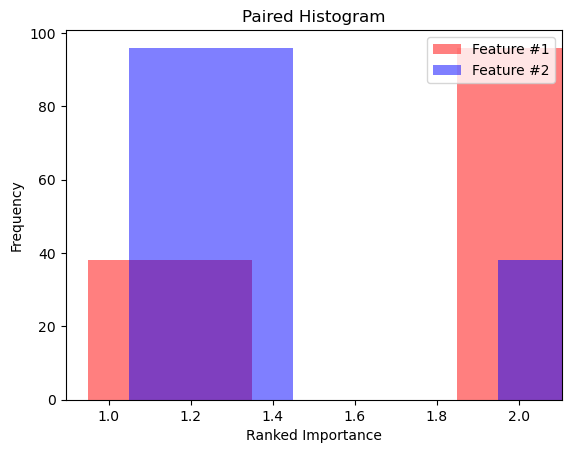

In [ ]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [ ]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "outside")

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.365882  0.467509  0.060028  0.019932  0.066963  0.160788  0.072834   
1    0.417968  0.526865  0.010895  0.017436  0.059940  0.266433  0.047938   
2    0.371145  0.573485  0.041056  0.009861  0.031074  0.249940  0.054656   
3    0.665515  0.444734  0.049755  0.002332  0.037100  0.169925  0.021878   
4    0.387816  0.647481  0.010901  0.004349  0.044848  0.243326  0.066636   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.506242  0.450557  0.006300  0.014224  0.102166  0.148780  0.037630   
130  0.281367  0.532424  0.014622  0.028539  0.053334  0.217060  0.114074   
131  0.569960  0.467156  0.009193  0.001748  0.073323  0.168968  0.030483   
132  0.447619  0.441143  0.011033  0.029998  0.035700  0.287065  0.066531   
133  0.520198  0.566316  0.024062  0.001746  0.057

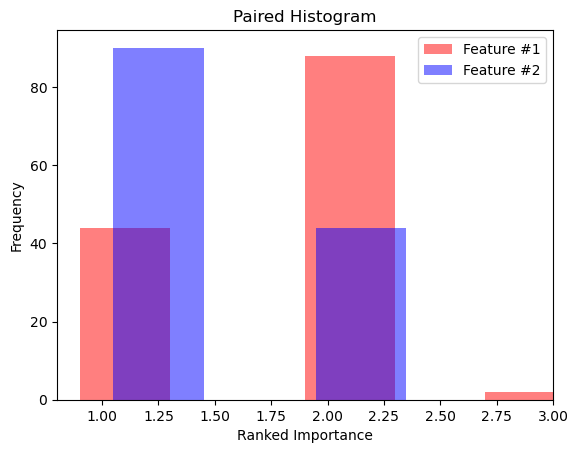

In [ ]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}$

In [27]:
# get MDI+ scores (higher r^2 value = greater importance)
Xtraincopy = copy.deepcopy(X_train)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "none")

In [29]:
var = None
var == None

True

In [28]:
# get MDI+ scores (higher r^2 value = greater importance)
Xtestcopy = copy.deepcopy(X_test)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True,
                                                    lfi_abs = "none", train_or_test = "test",
                                                    sample_split = None)

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
           0         1         2         3         4         5         6  \
0  -0.213956  0.361180  0.065797 -0.012176  0.034219  0.207805  0.061114   
1  -0.000343  0.323149 -0.033386 -0.021101  0.044373  0.220555  0.017237   
2  -0.556527  0.566311  0.002294  0.000844  0.021416 -0.271043 -0.009625   
3  -0.163165 -0.522586  0.003663  0.000793 -0.021905 -0.301561 -0.006066   
4  -0.440632  0.614201 -0.003225  0.000844 -0.000574 -0.298860  0.069638   
..       ...       ...       ...       ...       ...       ...       ...   
61 -0.420012 -0.459298 -0.015341  0.001005  0.040652  0.172204 -0.044853   
62 -0.496337 -0.501884  0.005395 -0.009218 -0.066419  0.114333 -0.023772   
63  0.305943 -0.579880  0.020643 -0.009619  0.032142  0.089096  0.028367   
64  0.054427  0.406116 -0.027123  0.007368 -0.041229  0.219835 -0.002591   
65 -0.553095  0.462157 -0.027867 -0.000320 -0.001789  0.15309

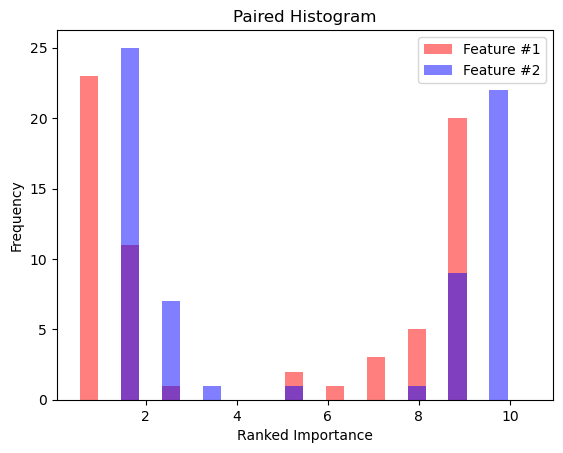

In [ ]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()